In [89]:
from f1Analysis import f1Analysis as f1
import matplotlib.pyplot as plt

data = f1.get_free_practice(2024, 'Japan') # Japan

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
events      WARNING 	Correcting user input 'Japan' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Practice 1 [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loadi

Best Params according to biggest cluster quality score:
eps                     0.100000
min_samples             6.000000
clean_cluster_score    14.915649
n_clusters              2.000000
Name: 3, dtype: float64
DBSCAN_Cluster
 0.0    235
-1.0    207
 1.0    205
Name: count, dtype: int64


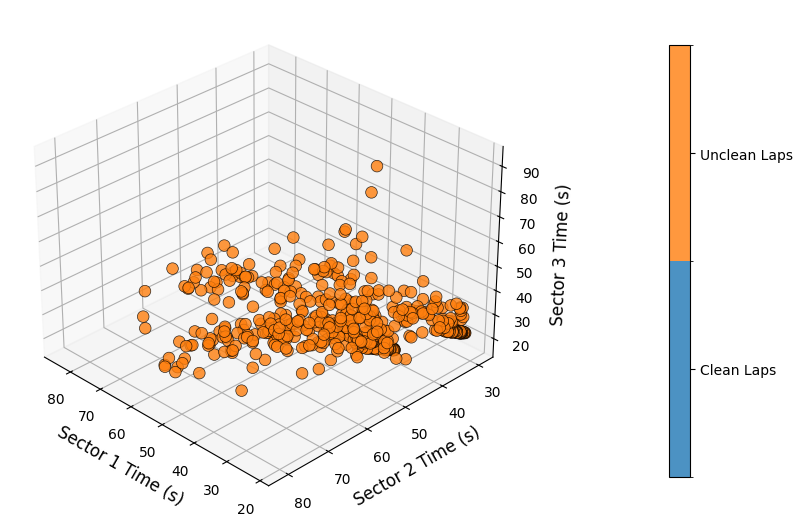

In [90]:
features = ['Sector1Time', 'Sector2Time', 'Sector3Time']
best_params = f1.tune_DBSCAN(features, data)
data = f1.perform_dbscan(best_params, data, features, 'DBSCAN_Cluster')

f1.plot_sectors(data, 'DBSCAN_Cluster')

Best Params according to biggest cluster quality score:
n_clusters          8.000000
cluster0_score     13.578173
inertia           170.592438
Name: 6, dtype: float64
KMeans_Cluster
7.0    241
1.0    222
4.0     72
5.0     44
2.0     31
6.0     18
0.0     16
3.0      3
Name: count, dtype: int64


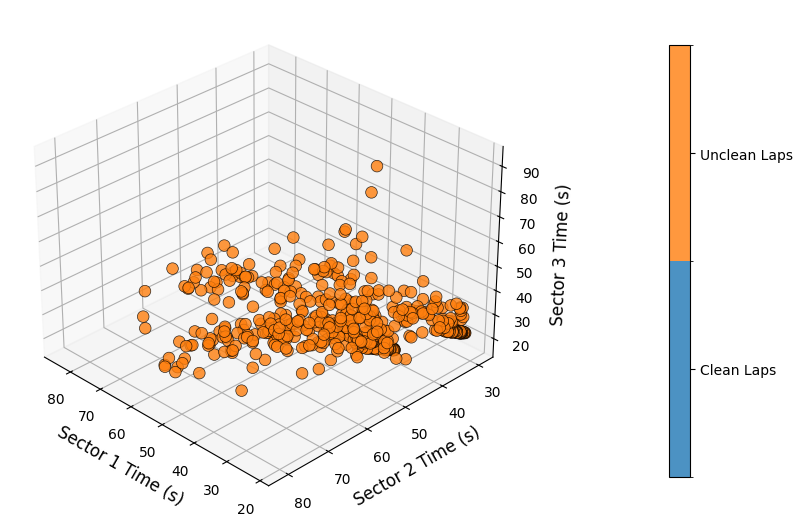

In [91]:
features = ['Sector1Time', 'Sector2Time', 'Sector3Time']
kmeans_params = f1.tune_KMeans(features, data)
data = f1.perform_kmeans(kmeans_params, data, features, 'KMeans_Cluster')

f1.plot_sectors(data, 'KMeans_Cluster')

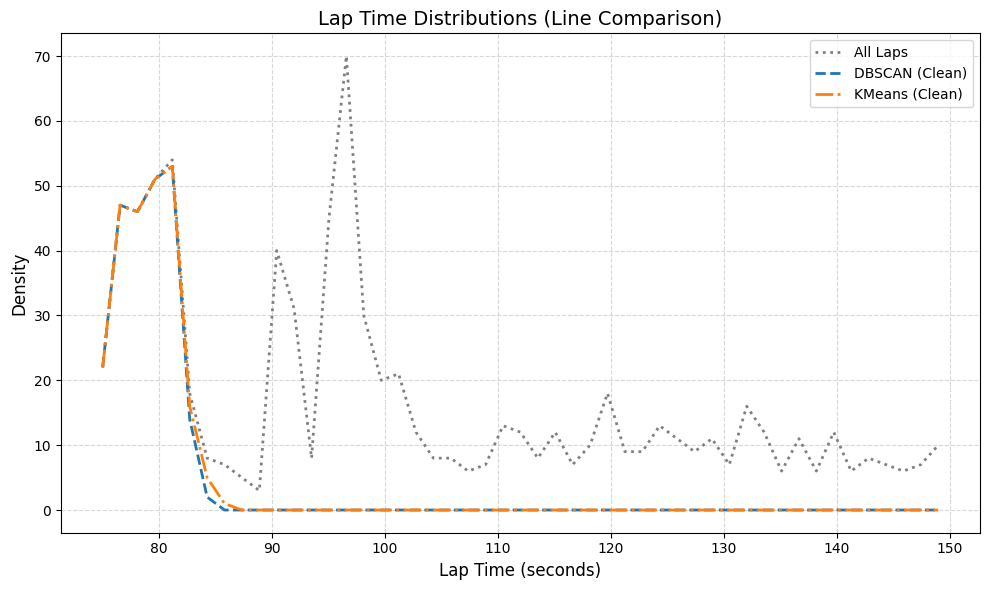

In [92]:
f1.plot_clean_distributions(data, 'DBSCAN_Cluster', 'KMeans_Cluster')

We can see that DBSCAN and Kmeans provide very similar results. We keep the data founded to be clean by both algorithms and on those we perform a second cleaning phase consisting in removing the laps with inconsistent sectors (Wich can be caused by driver mistakes or yellow flags). To do so we ask the lap to have a consistent differnece with the fastest secotors.

Number of laps with low variance: 230


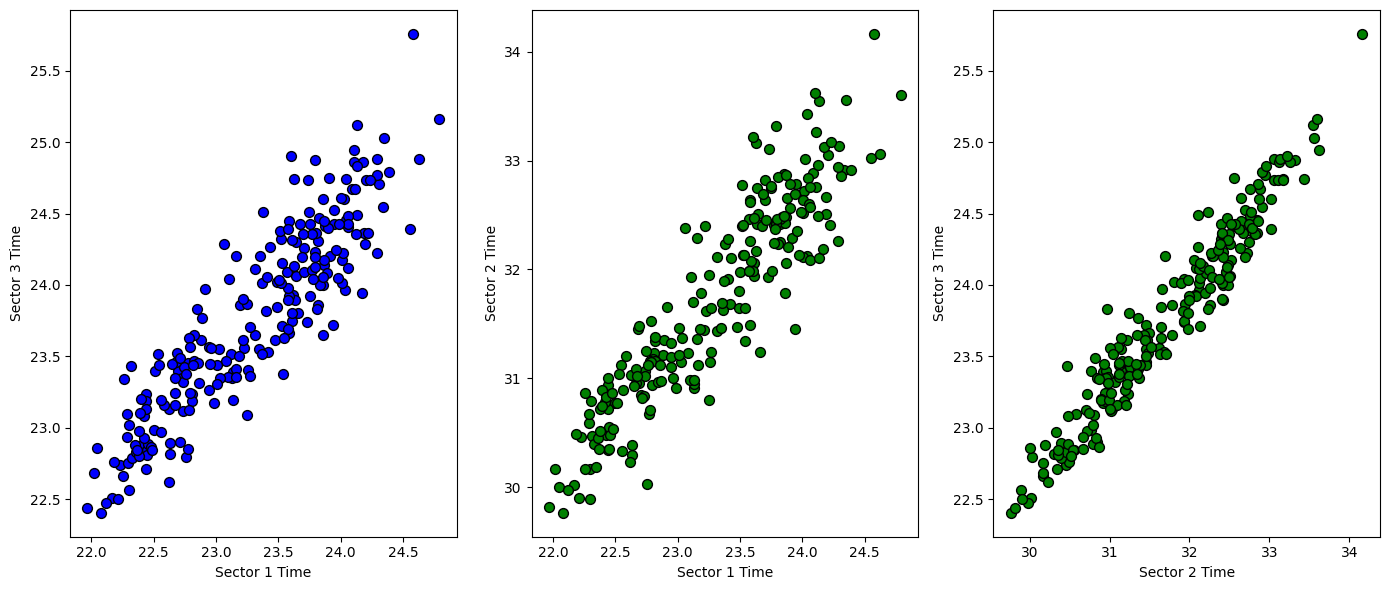

In [101]:
clean_DBSCAN = data['DBSCAN_Cluster'].value_counts().idxmax()
clean_KMeans = data['KMeans_Cluster'].value_counts().idxmax()
data = data[(data['KMeans_Cluster'] == clean_KMeans) & (data['DBSCAN_Cluster'] == clean_DBSCAN)]
data = f1.compute_sector_variance(data)

soglia = 1  # Threshold for low variance

low_variance_data = data[data['SectorVariance'] < soglia]

print(f"Number of laps with low variance: {len(low_variance_data)}")

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Plot Sector1Time vs Sector3Time
axes[0].scatter(low_variance_data['Sector1Time'], low_variance_data['Sector3Time'], c='blue', edgecolor='k', s=50)
axes[0].set_xlabel('Sector 1 Time')
axes[0].set_ylabel('Sector 3 Time')

# Plot Sector1Time vs Sector2Time
axes[1].scatter(low_variance_data['Sector1Time'], low_variance_data['Sector2Time'], c='green', edgecolor='k', s=50)
axes[1].set_xlabel('Sector 1 Time')
axes[1].set_ylabel('Sector 2 Time')

# Plot Sector1Time vs Sector2Time
axes[2].scatter(low_variance_data['Sector2Time'], low_variance_data['Sector3Time'], c='green', edgecolor='k', s=50)
axes[2].set_xlabel('Sector 2 Time')
axes[2].set_ylabel('Sector 3 Time')

plt.tight_layout()
plt.show()


In [94]:
import importlib
from f1Analysis import f1Analysis as f1
import matplotlib.pyplot as plt

# reload
importlib.reload(f1Analysis)

<module 'f1Analysis' from 'c:\\Users\\marti\\Desktop\\programmazione\\F1\\f1Analysis.py'>

We now train a decision tree to predict the laptimes using ['Compound', 'TyreLife', 'FuelLevel', 'Session'] as predictors

C:\Users\marti\AppData\Local\Temp\ipykernel_8472\3913956416.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_variance_data['LapTimeSeconds'] = low_variance_data['LapTime'].dt.total_seconds().round(2)


Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Best Parameters: {'regressor__ccp_alpha': 0.02, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 9}
Test MSE: 2.39
Test MAE: 1.19


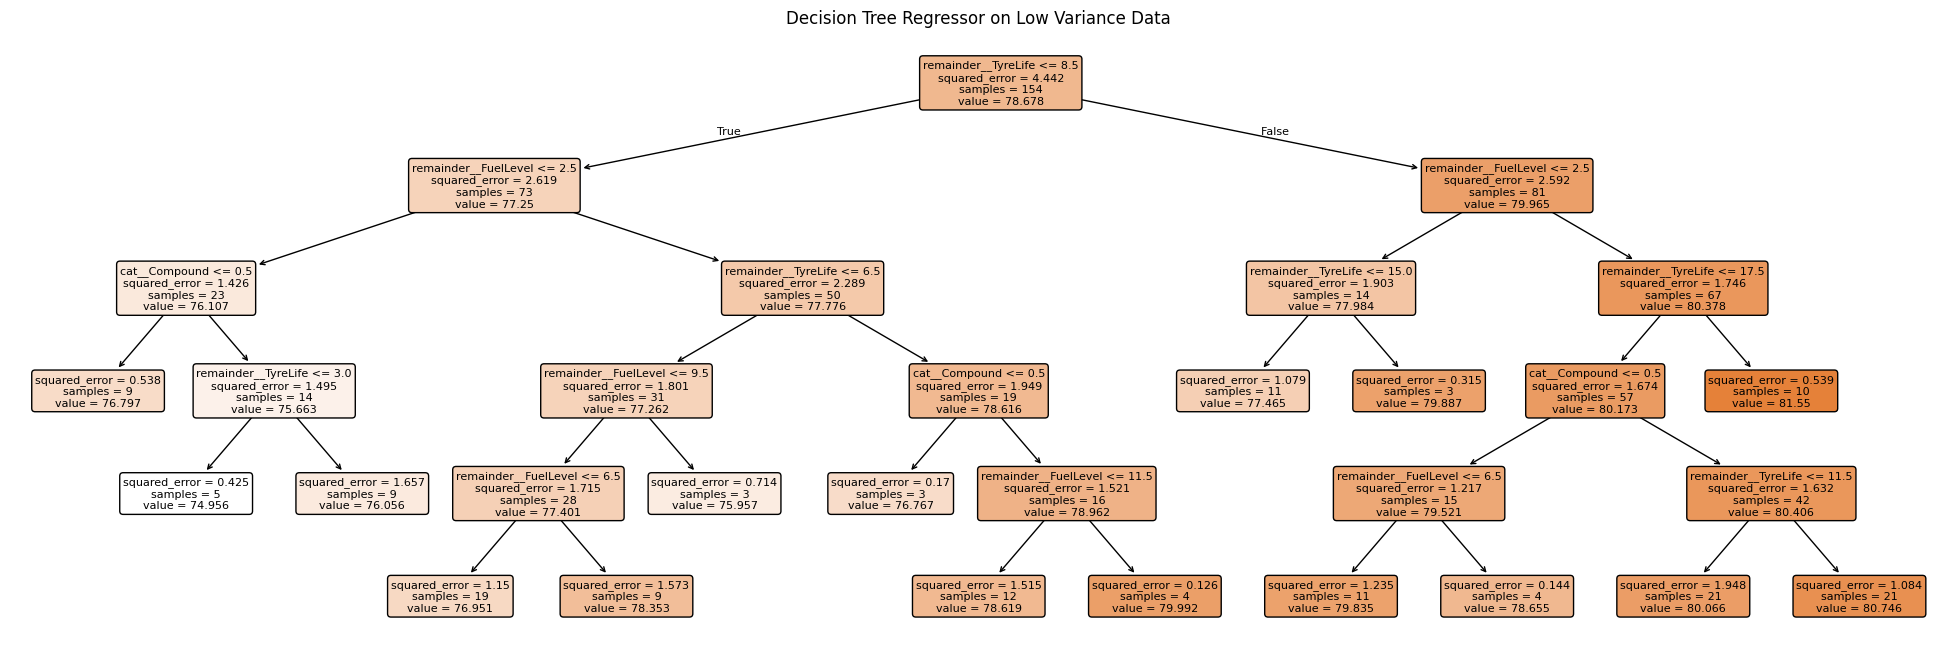

C:\Users\marti\AppData\Local\Temp\ipykernel_8472\3913956416.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_variance_data['DecisionTreeLapTime'] = best_model.predict(X)


In [105]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

low_variance_data['LapTimeSeconds'] = low_variance_data['LapTime'].dt.total_seconds().round(2)

# Step 2: Define features and target
X = low_variance_data[['Compound', 'TyreLife', 'FuelLevel', 'Session']]
y = low_variance_data['LapTimeSeconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define hyperparameter grid
param_grid = {
    'regressor__max_depth': [4, 5, 6, 7, 8, 9, 10, None],
    'regressor__min_samples_split': [6, 7,8,9, 10, 11, 12, 13, 14, 15],
    'regressor__min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10],
    'regressor__ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02]
}


# we use an ordinal encoder also for session because we consider the track evolution

# idea: use an encoder that gives value basing on how much usually the track improves
categorical_features = ['Compound', 'Session']
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        categories=[
            ['HARD', 'MEDIUM', 'SOFT'],  # for Compound
            ['FP1', 'FP2', 'FP3', 'Race', 'Q']  # for Session
        ]
    ), categorical_features)
], remainder='passthrough')


# Pipeline: preprocessing + regressor
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0))
])

# Set up grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Optional: evaluate
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")



# Step 6: Plot the decision tree
plt.figure(figsize=(25, 8))
plot_tree(
    best_model.named_steps['regressor'],
    feature_names=best_model.named_steps['preprocessing'].get_feature_names_out(),
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Regressor on Low Variance Data")
plt.show()

low_variance_data['DecisionTreeLapTime'] = best_model.predict(X)

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ------------------------------
# SETTINGS
# ------------------------------
predictors = ['Compound', 'TyreLife', 'FuelLevel', 'Session']
target = 'LapTimeSeconds'

# Prepare input (X) and target (y)
X = low_variance_data[predictors].values
y = low_variance_data[target].values

# Identify categorical columns
categorical_cols = ['Compound', 'Session']
categorical_idx = [predictors.index(col) for col in categorical_cols]

# One-hot encode categorical columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = X[:, categorical_idx]
categorical_encoded = ohe.fit_transform(categorical_data)

# Keep numeric columns
numeric_data = np.delete(X, categorical_idx, axis=1)

# Combine encoded categorical data with numeric data
X = np.hstack((categorical_encoded, numeric_data)).astype(float)

# ------------------------------
# TRAIN-TEST SPLIT
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# BUILD NEURAL NETWORK
# ------------------------------
model = Sequential([
    Dense(6, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(3, activation='relu'),
    Dense(1)  # Output for regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# ------------------------------
# TRAIN MODEL
# ------------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=35,
    verbose=1
)

# ------------------------------
# EVALUATE MODEL
# ------------------------------
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {test_mse:.2f}")

# ------------------------------
# PREDICT
# ------------------------------
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

# Mean squared error on training set
y_train_pred = model.predict(X_train)
print(f"Mean Squared Error on training set: {mean_squared_error(y_train, y_train_pred)}")


Epoch 1/1000


c:\Users\marti\Desktop\programmazione\F1\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5677.2593 - mse: 5677.2593 - val_loss: 5650.1772 - val_mse: 5650.1772
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5646.1011 - mse: 5646.1011 - val_loss: 5631.9897 - val_mse: 5631.9897
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5648.9629 - mse: 5648.9629 - val_loss: 5613.4487 - val_mse: 5613.4487
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5640.5903 - mse: 5640.5903 - val_loss: 5594.6328 - val_mse: 5594.6328
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5608.2778 - mse: 5608.2778 - val_loss: 5575.4800 - val_mse: 5575.4800
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5576.8770 - mse: 5576.8770 - val_loss: 5556.0078 - val_mse: 5556.0078
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5546.3110 - mse: 5546.3110 - val_loss: 5536.1626 - val_mse: 5536.1626
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5522.8008 - mse: 5522.8008 - val_loss: 5515.9385 - 

Because of the low amount of data, the decision tree seems to work better than the neural network.

We will now try to use the decision tree prediction to compute the best strategy in a dry race.

C:\Users\marti\AppData\Local\Temp\ipykernel_8472\1464651809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_variance_data['LapTimeSeconds'] = low_variance_data['LapTime'].dt.total_seconds().round(2)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'regressor__max_depth': 12, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Test MSE: 1.98
Test MAE: 1.15


C:\Users\marti\AppData\Local\Temp\ipykernel_8472\1464651809.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_variance_data['RandomForestLapTime'] = best_random_forest.predict(X)


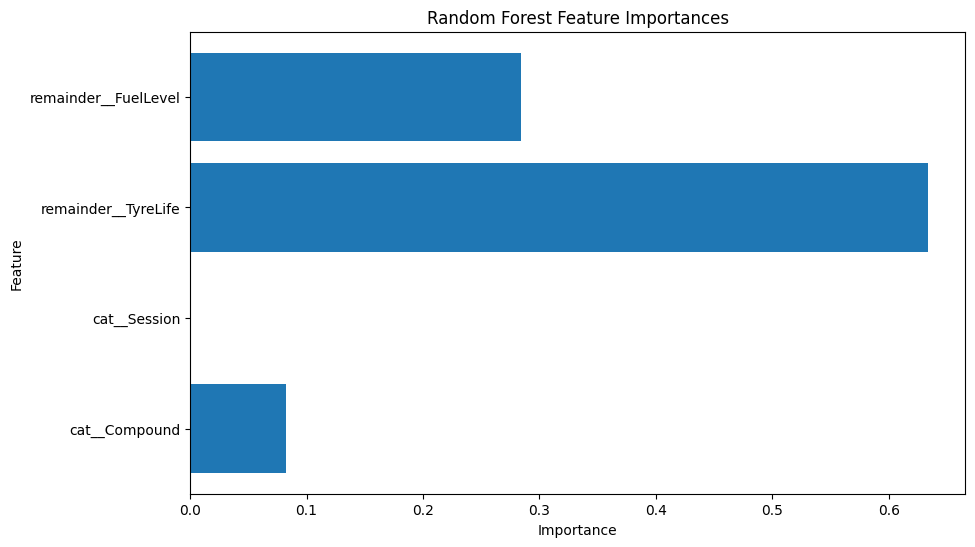

In [107]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Add LapTime in seconds
low_variance_data['LapTimeSeconds'] = low_variance_data['LapTime'].dt.total_seconds().round(2)

# Features and target
X = low_variance_data[['Compound', 'TyreLife', 'FuelLevel', 'Session']]
y = low_variance_data['LapTimeSeconds']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Preprocessing (OrdinalEncoder for categorical)
categorical_features = ['Compound', 'Session']
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        categories=[
            ['HARD', 'MEDIUM', 'SOFT'],          # for Compound
            ['FP1', 'FP2', 'FP3', 'Race', 'Q']  # for Session
        ]
    ), categorical_features)
], remainder='passthrough')

# Pipeline: preprocessing + random forest regressor
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0, n_jobs=-1))
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 8, 10, 12],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(X_train, y_train)

# Best random forest model
best_random_forest = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate
y_pred = best_random_forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Add predictions to dataframe
low_variance_data['RandomForestLapTime'] = best_random_forest.predict(X)

# Optional: Plot feature importances
importances = best_random_forest.named_steps['regressor'].feature_importances_
feature_names = best_random_forest.named_steps['preprocessing'].get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


The random forest seems to be the best model here. Let's now predict the best strategy for the race.

In [ ]:
import pandas as pd
from functools import lru_cache

model = best_random_forest
pit_time = 23.545
number_of_laps = 53
max_pits = 5
initial_fuel = number_of_laps + 2  # formation lap + in-lap

def create_lap(compound, tyre_life, fuel_level):
    return pd.DataFrame({
        'Compound': [compound],
        'TyreLife': [tyre_life],
        'FuelLevel': [fuel_level],
        'Session': ['FP3']
    })

# Cache predictions to avoid recomputing
@lru_cache(maxsize=None)
def predict_lap(compound, tyre_life, fuel_level):
    df = create_lap(compound, tyre_life, fuel_level)
    return float(model.predict(df)[0])

@lru_cache(maxsize=None)
def best_strategy(lap_number, last_compound, tyre_life, fuel_level, num_pits=0, compounds_used=frozenset()):
    # Race finished
    if lap_number > number_of_laps:
        if len(compounds_used) < 2:
            return (), float('inf')  # must use at least 2 compounds
        return (), 0.0
    
    if num_pits > max_pits:
        return (), float('inf')
    
    results = []

    # Option 1: Pit for new tyres
    for compound in ["HARD", "MEDIUM", "SOFT"]:
        lap_time = predict_lap(compound, 0, fuel_level) + pit_time
        next_strat, next_time = best_strategy(
            lap_number + 1, compound, 1, fuel_level - 1, num_pits + 1,
            compounds_used | frozenset([compound])
        )
        results.append((((lap_number, "Pit", compound, lap_time),) + next_strat, lap_time + next_time))

    # Option 2: No pit
    lap_time = predict_lap(last_compound, tyre_life, fuel_level)
    next_strat, next_time = best_strategy(
        lap_number + 1, last_compound, tyre_life + 1, fuel_level - 1, num_pits,
        compounds_used | frozenset([last_compound])
    )
    results.append((((lap_number, "No Pit", last_compound, lap_time),) + next_strat, lap_time + next_time))

    return min(results, key=lambda x: x[1])

def best_strategy_start():
    plans = {}
    for compound in ["HARD", "MEDIUM", "SOFT"]:
        plan, total_time = best_strategy(1, compound, 0, initial_fuel, 0, frozenset([compound]))
        plans[compound] = (plan, total_time)
    return plans

plans = best_strategy_start()
best_plan = min(plans.values(), key=lambda x: x[1])

print("Best total time:", best_plan[1])
for lap in best_plan[0]:
    print(lap)


Best total time: 4213.0599036137555
(1, 'No Pit', 'HARD', 77.63912464068612)
(2, 'No Pit', 'HARD', 77.63912464068612)
(3, 'No Pit', 'HARD', 77.63912464068612)
(4, 'No Pit', 'HARD', 77.70393651930587)
(5, 'No Pit', 'HARD', 77.75615644451953)
(6, 'No Pit', 'HARD', 77.6790052633396)
(7, 'No Pit', 'HARD', 77.66664887139822)
(8, 'No Pit', 'HARD', 77.92872432652315)
(9, 'No Pit', 'HARD', 78.01624930497606)
(10, 'No Pit', 'HARD', 78.77847011826792)
(11, 'No Pit', 'HARD', 79.104020924545)
(12, 'No Pit', 'HARD', 79.06693643681052)
(13, 'No Pit', 'HARD', 79.09972744746653)
(14, 'No Pit', 'HARD', 79.17948504320411)
(15, 'Pit', 'HARD', 101.18412464068612)
(16, 'No Pit', 'HARD', 77.63912464068612)
(17, 'No Pit', 'HARD', 77.63912464068612)
(18, 'No Pit', 'HARD', 77.70393651930586)
(19, 'No Pit', 'HARD', 77.75615644451953)
(20, 'No Pit', 'HARD', 77.67900526333959)
(21, 'No Pit', 'HARD', 77.66664887139821)
(22, 'No Pit', 'HARD', 77.92872432652314)
(23, 'No Pit', 'HARD', 78.01624930497606)
(24, 'No Pit

The best strategy seems to be a 3 stops one, it's important to notice that we are not considering traffic and the time that would be lost during overtakes.

The best race tyres seems to be the hards which is what we expected.

Further improvments could be obtained by adding previous race data into the prediction algorithm.

In [116]:
for e in low_variance_data.columns.tolist():
    print(e)

Time
Driver
DriverNumber
LapTime
LapNumber
Stint
PitOutTime
PitInTime
Sector1Time
Sector2Time
Sector3Time
Sector1SessionTime
Sector2SessionTime
Sector3SessionTime
SpeedI1
SpeedI2
SpeedFL
SpeedST
IsPersonalBest
Compound
TyreLife
FreshTyre
Team
LapStartTime
LapStartDate
TrackStatus
Position
Deleted
DeletedReason
FastF1Generated
IsAccurate
LapsInStint
OutLap
InLap
FuelLevel
Session
DBSCAN_Cluster
KMeans_Cluster
SectorVariance
LapTimeSeconds
DecisionTreeLapTime
RandomForestLapTime


In [122]:
print(low_variance_data.info())

<class 'fastf1.core.Laps'>
Index: 230 entries, 1 to 537
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Time                 230 non-null    timedelta64[ns]
 1   Driver               230 non-null    object         
 2   DriverNumber         230 non-null    object         
 3   LapTime              230 non-null    timedelta64[ns]
 4   LapNumber            230 non-null    float64        
 5   Stint                230 non-null    float64        
 6   PitOutTime           0 non-null      timedelta64[ns]
 7   PitInTime            0 non-null      timedelta64[ns]
 8   Sector1Time          230 non-null    float64        
 9   Sector2Time          230 non-null    float64        
 10  Sector3Time          230 non-null    float64        
 11  Sector1SessionTime   230 non-null    timedelta64[ns]
 12  Sector2SessionTime   230 non-null    timedelta64[ns]
 13  Sector3SessionTime   230 non-null   